## Блок 1: Импорты и основные настройки

Импортирует все необходимые Python библиотеки: `os` и `pathlib` для работы с файлами и путями, `pandas` для работы с табличными данными (особенно для файла submission), `numpy` для численных операций (эмбеддинги), `sentence_transformers` для загрузки и использования SBERT модели, `sklearn` для модели классификации (LinearSVC) и подбора параметров (GridSearchCV), `time` для замера времени выполнения, `collections.Counter` для подсчета классов, `nltk` для разбиения текста на предложения.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
# Закомментированы, так как не используются в текущей версии кода:
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
import time
from collections import Counter
import nltk # Используется для разбиения на предложения

print("Все необходимые библиотеки импортированы.")

c:\Users\0\miniconda3\envs\nmslib_clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\0\miniconda3\envs\nmslib_clean\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Все необходимые библиотеки импортированы.


## Блок 2: Конфигурация

Устанавливает основные параметры скрипта:

* `MODEL_NAME`: Имя SBERT модели для генерации эмбеддингов.
* `data_dir`: Путь к папке с текстовыми файлами (обучающими и тестовыми).
* `SENTENCES_PER_CHUNK`: Количество предложений, объединяемых в один "чанк" (кусок текста) для обучения.
* `training_files`: Словарь, связывающий имя автора с именем файла его текстов для обучения.
* `author_to_id_map`: Словарь, переводящий имена авторов в уникальные числовые ID (метки классов).

Проверяет, что для каждого автора в `training_files` есть соответствующий ID в `author_to_id_map`. Выводит информацию о конфигурации.

In [2]:
# --- Модель и Данные ---
MODEL_NAME = 'sberbank-ai/sbert_large_nlu_ru'  # Имя модели SBERT
data_dir = Path('E:/cv_project/writerextnd/') # !!! УБЕДИТЕСЬ, ЧТО ПУТЬ ПРАВИЛЬНЫЙ !!!
SENTENCES_PER_CHUNK = 10 # Количество предложений в одном чанке для обучения

# --- Обучающие данные: Имена авторов -> Файлы ---
training_files = {
    'Bradbury': 'Bradbury.txt',
    'Genri': 'Genri.txt',
    'Simak': 'Simak.txt',
    'Bulgakov': 'Bulgakov.txt',
    'Strugatskie': 'Strugatskie.txt',
    'Fry': 'Fry.txt'
}

# --- Карта имен авторов к их числовым ID ---
author_to_id_map = {
    'Bradbury': 3,
    'Genri': 0,
    'Simak': 1,
    'Bulgakov': 2,
    'Strugatskie': 5,
    'Fry': 4
}

# --- Проверка соответствия имен авторов и ID ---
missing_authors = [author for author in training_files if author not in author_to_id_map]
if missing_authors:
    raise ValueError(f"Ошибка: Не найдены ID для следующих авторов в author_to_id_map: {missing_authors}")
else:
    print("Конфигурация авторов и ID проверена.")

print(f"Модель SBERT: {MODEL_NAME}")
print(f"Папка с данными: {data_dir}")
print(f"Предложений в чанке: {SENTENCES_PER_CHUNK}")
print(f"Авторы для обучения: {list(training_files.keys())}")

Конфигурация авторов и ID проверена.
Модель SBERT: sberbank-ai/sbert_large_nlu_ru
Папка с данными: E:\cv_project\writerextnd
Предложений в чанке: 10
Авторы для обучения: ['Bradbury', 'Genri', 'Simak', 'Bulgakov', 'Strugatskie', 'Fry']


## Блок 3: Проверка и загрузка NLTK данных

Обеспечивает наличие необходимых данных ('punkt') для библиотеки NLTK, которая используется в Блоке 5 для разбиения текста на предложения (`nltk.sent_tokenize`).

Проверяет, установлен ли пакет 'punkt'. Если нет, пытается его скачать. Обрабатывает возможные ошибки при скачивании.

In [3]:
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK пакет 'punkt' для токенизации предложений найден.")
except nltk.downloader.DownloadError:
    print("Загрузка пакета 'punkt' для nltk...")
    nltk.download('punkt')
    print("Пакет 'punkt' загружен.")
except Exception as e:
    print(f"Не удалось проверить/загрузить nltk 'punkt': {e}")
    print("Попробуйте установить вручную: python -m nltk.downloader punkt")
    # exit() # Если автоматическая загрузка не удалась

NLTK пакет 'punkt' для токенизации предложений найден.


## Блок 5: Загрузка и нарезка обучающих данных

Читает текстовые файлы авторов из `training_files`, разбивает их на предложения с помощью NLTK, а затем объединяет предложения в чанки заданного размера (`SENTENCES_PER_CHUNK`).
Проходит по каждому автору и файлу:

* Читает текст файла.
* Разбивает на предложения (`nltk.sent_tokenize` с указанием русского языка).
* Формирует чанки из предложений.
* Сохраняет текст каждого чанка в `chunked_train_texts` и соответствующий ID автора в `chunked_train_author_ids`.
* Отслеживает ошибки чтения файлов и общее количество созданных чанков.
* Выполняет критическую проверку: если не удалось создать ни одного чанка, скрипт завершается.

In [4]:
chunked_train_texts = []      # Список для хранения текстовых чанков
chunked_train_author_ids = [] # Список для хранения ID авторов для каждого чанка
errors_loading_train = []     # Список для ошибок при загрузке обучения

print(f"\nЧтение и нарезка обучающих данных из папки: {data_dir}")
print(f"Создание чанков по {SENTENCES_PER_CHUNK} предложений.")

total_chunks_created = 0
for author, filename in training_files.items():
    file_path = data_dir / filename
    author_id = author_to_id_map[author]
    chunks_for_author = 0
    try:
        if file_path.is_file():
            print(f" - Обработка файла: {filename} (Автор: {author}, ID: {author_id})")
            text = file_path.read_text(encoding='utf-8')
            if not text.strip():
                print(f"   - Предупреждение: Файл {filename} пустой.")
                continue # Переходим к следующему файлу

            # Разбиваем текст на предложения с указанием языка
            sentences = nltk.sent_tokenize(text, language='russian')
            print(f"   - Найдено предложений: {len(sentences)}")

            # Делим предложения на чанки
            for i in range(0, len(sentences), SENTENCES_PER_CHUNK):
                chunk_sentences = sentences[i : i + SENTENCES_PER_CHUNK]
                chunk_text = " ".join(chunk_sentences)
                # Добавляем только непустые чанки
                if chunk_text.strip():
                    chunked_train_texts.append(chunk_text)
                    chunked_train_author_ids.append(author_id)
                    chunks_for_author += 1

            print(f"   - Создано чанков: {chunks_for_author}")
            total_chunks_created += chunks_for_author
        else:
            error_msg = f" - Ошибка: Обучающий файл не найден: {file_path}"
            print(error_msg)
            errors_loading_train.append(error_msg)
    except Exception as e:
        error_msg = f" - Ошибка при чтении/обработке файла {file_path}: {e}"
        print(error_msg)
        errors_loading_train.append(error_msg)

print(f"\nВсего создано обучающих чанков: {total_chunks_created}")

# Проверка, были ли созданы чанки
if total_chunks_created == 0:
    if not errors_loading_train:
        print("!!! КРИТИЧЕСКАЯ ОШИБКА: Не было создано ни одного обучающего чанка. Проверьте файлы и параметр SENTENCES_PER_CHUNK.")
    else:
         print("!!! КРИТИЧЕСКАЯ ОШИБКА: Не было создано ни одного обучающего чанка из-за ошибок чтения файлов.")
    exit() 


Чтение и нарезка обучающих данных из папки: E:\cv_project\writerextnd
Создание чанков по 10 предложений.
 - Обработка файла: Bradbury.txt (Автор: Bradbury, ID: 3)
   - Найдено предложений: 23934
   - Создано чанков: 2394
 - Обработка файла: Genri.txt (Автор: Genri, ID: 0)
   - Найдено предложений: 12668
   - Создано чанков: 1267
 - Обработка файла: Simak.txt (Автор: Simak, ID: 1)
   - Найдено предложений: 24444
   - Создано чанков: 2445
 - Обработка файла: Bulgakov.txt (Автор: Bulgakov, ID: 2)
   - Найдено предложений: 21268
   - Создано чанков: 2127
 - Обработка файла: Strugatskie.txt (Автор: Strugatskie, ID: 5)
   - Найдено предложений: 29589
   - Создано чанков: 2959
 - Обработка файла: Fry.txt (Автор: Fry, ID: 4)
   - Найдено предложений: 53640
   - Создано чанков: 5364

Всего создано обучающих чанков: 16556


## Блок 6: Загрузка тестовых данных

Загружает тексты из файлов, предназначенных для предсказания (имена которых начинаются с 'author', например, 'author1.txt').

* Находит все файлы по шаблону `author*.txt` в `data_dir`.
* Пытается отсортировать ID файлов (часть имени без 'author') по числовому значению.
* Читает содержимое каждого найденного и непустого файла в словарь `test_data`, где ключ - ID файла (например, 'author1'), а значение - текст.
* Сохраняет отсортированные ID загруженных файлов в `test_ids_sorted`.
* Отслеживает ошибки чтения тестовых файлов.

In [5]:
test_data = {}
test_ids_sorted = []
errors_loading_test = []

print("\nЗагрузка тестовых текстов (файлы 'author*.txt')...")
test_files_paths = sorted(list(data_dir.glob('author*.txt')))

if not test_files_paths:
      error_msg = f" - Ошибка: Тестовые файлы ('author*.txt') не найдены в {data_dir}"
      print(error_msg)
      errors_loading_test.append(error_msg)
else:
    try:
        test_ids_sorted = sorted(
            [fp.stem for fp in test_files_paths],
            key=lambda x: int(x.replace('author', ''))
        )
        print(" - Тестовые ID отсортированы по числовому значению.")
    except ValueError:
        print(" - Предупреждение: Не удалось отсортировать тестовые ID по числу. Используется стандартная сортировка строк.")
        test_ids_sorted = sorted([fp.stem for fp in test_files_paths])

    test_files_paths_map = {fp.stem: fp for fp in test_files_paths}

    for file_id in test_ids_sorted:
        file_path = test_files_paths_map[file_id]
        try:
            text = file_path.read_text(encoding='utf-8')
            if text.strip():
                test_data[file_id] = text
                print(f"   - Загружен {file_path.name} (ID: {file_id}), символов: {len(text)}")
            else:
                print(f"   - Предупреждение: Тестовый файл {file_path.name} пустой, пропускается.")
        except Exception as e:
            error_msg = f"   - Ошибка при чтении тестового файла {file_path}: {e}"
            print(error_msg)
            errors_loading_test.append(error_msg)

test_ids_sorted = [id_ for id_ in test_ids_sorted if id_ in test_data]

if not test_data:
    print(" - Предупреждение: Не загружено ни одного тестового текста.")


Загрузка тестовых текстов (файлы 'author*.txt')...
 - Тестовые ID отсортированы по числовому значению.
   - Загружен author1.txt (ID: author1), символов: 1629
   - Загружен author2.txt (ID: author2), символов: 2459
   - Загружен author3.txt (ID: author3), символов: 1323
   - Загружен author4.txt (ID: author4), символов: 2103
   - Загружен author5.txt (ID: author5), символов: 3207
   - Загружен author6.txt (ID: author6), символов: 2181
   - Загружен author7.txt (ID: author7), символов: 9949
   - Загружен author8.txt (ID: author8), символов: 5264
   - Загружен author9.txt (ID: author9), символов: 19488
   - Загружен author10.txt (ID: author10), символов: 1657
   - Загружен author11.txt (ID: author11), символов: 2633
   - Загружен author12.txt (ID: author12), символов: 3946
   - Загружен author13.txt (ID: author13), символов: 2090
   - Загружен author14.txt (ID: author14), символов: 2013
   - Загружен author15.txt (ID: author15), символов: 2354
   - Загружен author16.txt (ID: author16), 

## Блок 7: Отчет об ошибках загрузки

Информирует, если на этапах загрузки обучающих (Блок 5) или тестовых (Блок 6) данных произошли ошибки.

Собирает все сообщения об ошибках из `errors_loading_train` и `errors_loading_test`. Если список ошибок не пуст, выводит их на экран.

In [6]:
all_errors = errors_loading_train + errors_loading_test
if all_errors:
    print("\n--- Обнаружены ошибки при загрузке файлов ---")
    for err in all_errors:
        print(err)
    # print("Прерывание выполнения из-за ошибок загрузки.")
    # exit()

## Блок 8: Подготовка данных для модели и проверка распределения классов

Финализирует списки текстов и меток для обучения и теста. Проверяет сбалансированность обучающих данных по классам (авторам).

* Присваивает переменным `train_texts`, `train_author_ids`, `test_texts` данные, подготовленные в предыдущих блоках.
* Выводит количество обучающих чанков и тестовых текстов.
* Считает, сколько чанков приходится на каждого автора (`Counter(train_author_ids)`).
* Определяет минимальное количество чанков на один класс (`min_samples_per_class`).
* Предупреждает пользователя, если какой-то класс имеет слишком мало примеров (меньше 2), что сделает невозможной стандартную кросс-валидацию в Блоке 11. Если есть класс с 0 примеров, скрипт завершается.

In [7]:
train_texts = chunked_train_texts
train_author_ids = chunked_train_author_ids

test_texts = [test_data[id_] for id_ in test_ids_sorted if id_ in test_data]

print(f"\nПодготовлено {len(train_texts)} обучающих чанков.")
if test_texts:
    print(f"Подготовлено {len(test_texts)} тестовых текстов для предсказания.")
else:
    print("Тестовые тексты для предсказания отсутствуют или не были загружены.")

class_counts = Counter(train_author_ids)
print(f"\nРаспределение классов в обучении (по чанкам): {class_counts}")

min_samples_per_class = 0
if class_counts:
    min_samples_per_class = min(class_counts.values())
print(f"Минимальное количество образцов (чанков) на класс: {min_samples_per_class}")

if min_samples_per_class < 2:
    print("\n!!! ПРЕДУПРЕЖДЕНИЕ !!!")
    print(f"После нарезки у одного или нескольких классов меньше 2 образцов ({min_samples_per_class}).")
    print("Стандартная кросс-валидация (5-fold) невозможна.")
    print("Попробуйте уменьшить SENTENCES_PER_CHUNK или проверьте объем исходных текстов.")
    if min_samples_per_class < 1:
         print("!!! КРИТИЧЕСКАЯ ОШИБКА: Есть класс(ы) без единого обучающего образца!")
         exit() # Обучение невозможно


Подготовлено 16556 обучающих чанков.
Подготовлено 21 тестовых текстов для предсказания.

Распределение классов в обучении (по чанкам): Counter({4: 5364, 5: 2959, 1: 2445, 3: 2394, 2: 2127, 0: 1267})
Минимальное количество образцов (чанков) на класс: 1267


## Блок 9: Генерация эмбеддингов для обучающих данных

Обучение длится 2 час 45 мин.

Преобразует обучающие текстовые чанки в числовые векторы (эмбеддинги) с помощью SBERT модели.

* **Загружает SBERT модель (энкодер) `SentenceTransformer(MODEL_NAME)`.**
* Использует метод `.encode()` этой модели для получения эмбеддингов `train_embeddings` из `train_texts`. Включает нормализацию эмбеддингов.
* Замеряет и выводит время генерации эмбеддингов и размер полученной матрицы.

In [8]:
model_st = SentenceTransformer(MODEL_NAME)

In [9]:
print(f"\nГенерация эмбеддингов для {len(train_texts)} обучающих чанков с помощью {MODEL_NAME}...")
start_time = time.time()
train_embeddings = model_st.encode(
    train_texts,
    show_progress_bar=True,
    normalize_embeddings=True 
)
end_time = time.time()
print(f"Генерация обучающих эмбеддингов заняла: {end_time - start_time:.2f} сек.")
print(f"Размер матрицы обучающих эмбеддингов: {train_embeddings.shape}")


Генерация эмбеддингов для 16556 обучающих чанков с помощью sberbank-ai/sbert_large_nlu_ru...


Batches: 100%|██████████| 518/518 [1:47:41<00:00, 12.47s/it]  

Генерация обучающих эмбеддингов заняла: 6462.11 сек.
Размер матрицы обучающих эмбеддингов: (16556, 1024)


## Блок 10: Генерация эмбеддингов для тестовых данных

Преобразует тестовые тексты в эмбеддинги с помощью той же SBERT модели.
Если тестовые тексты (`test_texts`) были загружены:

* Использует метод `.encode()` модели `model_st` для получения эмбеддингов `test_embeddings` из `test_texts`. Также с нормализацией.
* Замеряет и выводит время генерации и размер матрицы.
* Если тестовых текстов нет, выводит соответствующее сообщение.

In [10]:
test_embeddings = np.array([]) # Инициализируем пустым массивом

if test_texts:
    print(f"\nГенерация эмбеддингов для {len(test_texts)} тестовых текстов...")
    start_time = time.time()
    test_embeddings = model_st.encode(
        test_texts,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    end_time = time.time()
    print(f"Генерация тестовых эмбеддингов заняла: {end_time - start_time:.2f} сек.")
    if test_embeddings.ndim == 2: # Убедимся, что это двумерный массив
         print(f"Размер матрицы тестовых эмбеддингов: {test_embeddings.shape}")
    else:
         print(f"Получен массив эмбеддингов неожиданной размерности: {test_embeddings.shape}")
         test_embeddings = np.array([])
else:
    print("\nНет тестовых текстов для генерации эмбеддингов.")


Генерация эмбеддингов для 21 тестовых текстов...


Batches: 100%|██████████| 1/1 [00:21<00:00, 21.76s/it]

Генерация тестовых эмбеддингов заняла: 21.78 сек.
Размер матрицы тестовых эмбеддингов: (21, 1024)


## Блок 11: Обучение классификатора (LinearSVC с GridSearchCV)

Обучает модель машинного обучения (`LinearSVC`) предсказывать ID автора по эмбеддингу текста. Использует `GridSearchCV` для поиска лучших гиперпараметров (`C`, `loss`) модели.

* Определяет сетку параметров (`param_grid`) для поиска.
* Инициализирует базовую модель `LinearSVC` с балансировкой классов.
* Определяет количество фолдов для кросс-валидации (`n_splits`), ограничивая его 5 или минимальным количеством сэмплов на класс.
* **Если `n_splits >= 2`:** Запускает `GridSearchCV` для поиска лучших параметров `C` и `loss` для `LinearSVC` на обучающих эмбеддингах и ID. Сохраняет лучшую найденную модель в `classifier`.
* **Если `n_splits < 2` или `GridSearchCV` вызвал ошибку:** Обучает `LinearSVC` с параметрами по умолчанию (или заданными вручную) без кросс-валидации и подбора. Сохраняет модель в `classifier`.
* Выводит информацию о процессе обучения, найденных параметрах и качестве на кросс-валидации (если она проводилась).
* Проверяет, что классификатор `classifier` был успешно создан и обучен, иначе завершает скрипт.

In [11]:
classifier = None # Инициализируем классификатор

print("\nОбучение классификатора LinearSVC...")

# param_grid = {'C': [0.1, 1, 10, 100, 1000]} # Лучший результат при С = 10! - точность 91%
# param_grid = {'C': [9, 9.5, 10, 10.5, 11]} # попробовать помельче шаг, для уточности
# Добавление каждого нового параметра умножает количество комбинаций. 6(вар. С) * 2 (вар. loss) = 12

# param_grid = {
#     'C': [5, 8, 10, 12, 15, 20], 
#     'loss': ['hinge', 'squared_hinge'] # Лучшие параметры найдены: {'C': 8, 'loss': 'squared_hinge'} кросс-валидации (5-fold): 0.8700
# }


param_grid = {
    'C': [6, 7, 8, 9, 10],
    'loss': ['hinge', 'squared_hinge'] # Лучшие параметры найдены: {'C': 7, 'loss': 'squared_hinge'} кросс-валидации (5-fold): 0.8700
}

base_classifier = LinearSVC(random_state=42, dual=True, max_iter=2000, class_weight='balanced') # dual='auto' с версии 1.2

n_splits = min(5, min_samples_per_class) # 5 фолдов, равное числу образцов

if n_splits < 2:
    print(f"\n!!! Невозможно выполнить кросс-валидацию (n_splits={n_splits} < 2).")
    print("Обучение будет выполнено без GridSearchCV с параметром C=1.0.")
    classifier = LinearSVC(C=1.0, random_state=42, dual=True, max_iter=2000, class_weight='balanced')
    start_time_fit = time.time()
    try:
        classifier.fit(train_embeddings, train_author_ids)
        print(f"Обучение базового классификатора заняло: {time.time() - start_time_fit:.2f} сек.")
    except Exception as fit_e:
        print(f"!!! КРИТИЧЕСКАЯ ОШИБКА при обучении базового LinearSVC: {fit_e}")
        exit() # Прерываем, если даже базовая модель не обучилась
else:
    print(f"Подбор гиперпараметров для LinearSVC с помощью GridSearchCV ({n_splits}-fold CV)...")
    # n_jobs=-1 использует все доступные ядра процессора
    # verbose=2 показывает больше информации о процессе поиска
    grid_search = GridSearchCV(base_classifier, param_grid, cv=n_splits, n_jobs=-1, verbose=2)

    start_time_grid = time.time()
    try:
        # Обучаем GridSearchCV на обучающих данных
        grid_search.fit(train_embeddings, train_author_ids)
        print(f"\nGridSearchCV завершен за: {time.time() - start_time_grid:.2f} сек.")

        # Получаем лучший классификатор по результатам GridSearchCV
        classifier = grid_search.best_estimator_
        print(f"Лучшие параметры найдены: {grid_search.best_params_}")
        print(f"Лучшая средняя точность на кросс-валидации ({n_splits}-fold): {grid_search.best_score_:.4f}")
        print("Классификатор (LinearSVC с лучшими параметрами) успешно обучен.")

    except ValueError as e:
        print(f"\n!!! ОШИБКА во время GridSearchCV: {e}")
        print("Возможная причина: недостаточно данных или проблемы с параметрами.")
        print("Попытка обучить модель без GridSearchCV с параметром C=1.0...")
        classifier = LinearSVC(C=1.0, random_state=42, dual=True, max_iter=2000, class_weight='balanced')
        start_time_fit_alt = time.time()
        try:
            classifier.fit(train_embeddings, train_author_ids)
            print(f"Обучение базового классификатора заняло: {time.time() - start_time_fit_alt:.2f} сек.")
        except Exception as fit_e_alt:
            print(f"!!! КРИТИЧЕСКАЯ ОШИБКА при обучении базового LinearSVC после ошибки GridSearchCV: {fit_e_alt}")
            exit() # Прерываем, если и базовая модель не обучилась

# Финальная проверка, что классификатор был создан
if classifier is None:
    print("!!! КРИТИЧЕСКАЯ ОШИБКА: Классификатор не был инициализирован или обучен. Выход.")
    exit()


Обучение классификатора LinearSVC...
Подбор гиперпараметров для LinearSVC с помощью GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

GridSearchCV завершен за: 151.12 сек.
Лучшие параметры найдены: {'C': 7, 'loss': 'squared_hinge'}
Лучшая средняя точность на кросс-валидации (5-fold): 0.8700
Классификатор (LinearSVC с лучшими параметрами) успешно обучен.


## Блок 12: Предсказание на тестовых данных и создание файла submission

Использует обученный классификатор для предсказания авторов тестовых текстов и сохраняет результаты в файл формата CSV для отправки (например, на kaggle).
Если есть тестовые эмбеддинги и обученный классификатор:

* Получает предсказанные ID авторов (`predicted_author_ids`) для `test_embeddings` с помощью `classifier.predict()`.
* Выводит несколько примеров предсказаний.
* Создает `pandas.DataFrame` с двумя колонками: 'id' (отсортированные ID тестовых файлов) и 'label' (предсказанные ID авторов).
* Сохраняет этот DataFrame в CSV-файл `submission_sbert_chunked_gridsearch_v2.csv`.
* Выводит путь к созданному файлу и его первые строки.
* Обрабатывает возможные ошибки при сохранении файла.

In [ ]:
if test_embeddings.size > 0 and classifier is not None:
    print("\nПолучение предсказаний для тестовых данных...")
    start_time = time.time()
    predicted_author_ids = classifier.predict(test_embeddings)
    end_time = time.time()
    print(f"Предсказание заняло: {end_time - start_time:.2f} сек.")
    print(f"Предсказания (числовые ID) получены для {len(predicted_author_ids)} тестовых отрывков.")

    # Вывод примеров предсказаний
    print("\nПримеры предсказаний:")
    id_to_author_map = {v: k for k, v in author_to_id_map.items()} # Обратная карта для имен
    for i in range(min(5, len(predicted_author_ids))):
         pred_id = predicted_author_ids[i]
         pred_author = id_to_author_map.get(pred_id, f"Неизвестный ID {pred_id}")
         print(f"  ID файла: {test_ids_sorted[i]} -> Предсказан ID: {pred_id} (Автор: {pred_author})")

    # --- Создание DataFrame для submission ---
    submission_df = pd.DataFrame({
        'id': test_ids_sorted,      # Используем отсортированные ID
        'label': predicted_author_ids # Предсказанные ID
    })

    # --- Сохранение в CSV ---
    submission_filename = "submission_sbert_chunked_gridsearch_v2.csv"
    submission_path = submission_filename # Сохраняем в ту же папку с данными
    try:
        submission_df.to_csv(submission_path, index=False, sep=',')
        print(f"\nФайл для отправки '{submission_path.resolve()}' успешно создан.")
        print("Содержимое файла (первые 5 строк):")
        print(submission_df.head().to_string()) # Используем to_string для лучшего форматирования в консоли
    except Exception as e:
        print(f"\n!!! ОШИБКА при сохранении файла submission: {e}")

elif classifier is None:
     print("\nПредсказание невозможно: классификатор не был обучен.")
else: # test_embeddings.size == 0
    print("\nНет тестовых данных для предсказания или создания файла submission.")

print("\n--- Скрипт завершил работу ---")


Получение предсказаний для тестовых данных...
Предсказание заняло: 0.00 сек.
Предсказания (числовые ID) получены для 21 тестовых отрывков.

Примеры предсказаний:
  ID файла: author1 -> Предсказан ID: 0 (Автор: Genri)
  ID файла: author2 -> Предсказан ID: 1 (Автор: Simak)
  ID файла: author3 -> Предсказан ID: 0 (Автор: Genri)
  ID файла: author4 -> Предсказан ID: 2 (Автор: Bulgakov)
  ID файла: author5 -> Предсказан ID: 0 (Автор: Genri)

Файл для отправки 'E:\cv_project\writerextnd\submission_sbert_chunked_gridsearch_v2.csv' успешно создан.
Содержимое файла (первые 5 строк):
        id  label
0  author1      0
1  author2      1
2  author3      0
3  author4      2
4  author5      0

--- Скрипт завершил работу ---


## Блок 13: Дополнительный анализ результатов (на обучающих данных)

Проводит дополнительный анализ качества модели на обучающих данных с использованием кросс-валидации и визуализации.

* Импортирует библиотеки для визуализации (`matplotlib`, `seaborn`) и метрик/инструментов (`sklearn`).
* **Матрица ошибок:** Если кросс-валидация была возможна (`n_splits >= 2`), получает предсказания на обучающих данных (`cross_val_predict`), строит матрицу ошибок (`confusion_matrix`) и отображает ее (`ConfusionMatrixDisplay`), сохраняя в файл `confusion_matrix_cv.png`.
* **Визуализация t-SNE:** Использует t-SNE для снижения размерности обучающих эмбеддингов до 2D и строит диаграмму рассеяния, где точки окрашены по авторам. Это помогает визуально оценить, насколько хорошо эмбеддинги разделяют классы. Использует подвыборку, если точек слишком много. Сохраняет график в `tsne_embeddings.png`.
* **Анализ ошибок:** Если были получены предсказания кросс-валидации, находит примеры чанков, которые были неверно классифицированы, и выводит текст этих чанков вместе с истинным и предсказанным автором.


--- Запуск дополнительного анализа ---

1. Построение матрицы ошибок (кросс-валидация на обучающих данных)...


<Figure size 1000x800 with 0 Axes>

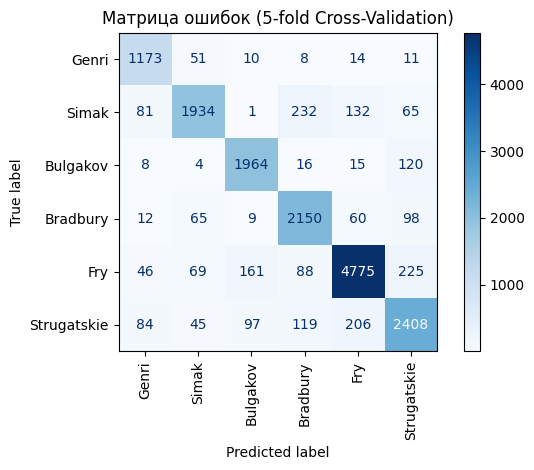


2. Визуализация эмбеддингов обучающих чанков с помощью t-SNE...
   (Может занять некоторое время для большого количества точек)
   - Слишком много точек (16556), используется подвыборка из 5000 точек для t-SNE.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.714s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.221248
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.137253
[t-SNE] KL divergence after 1000 iterations: 2.444030


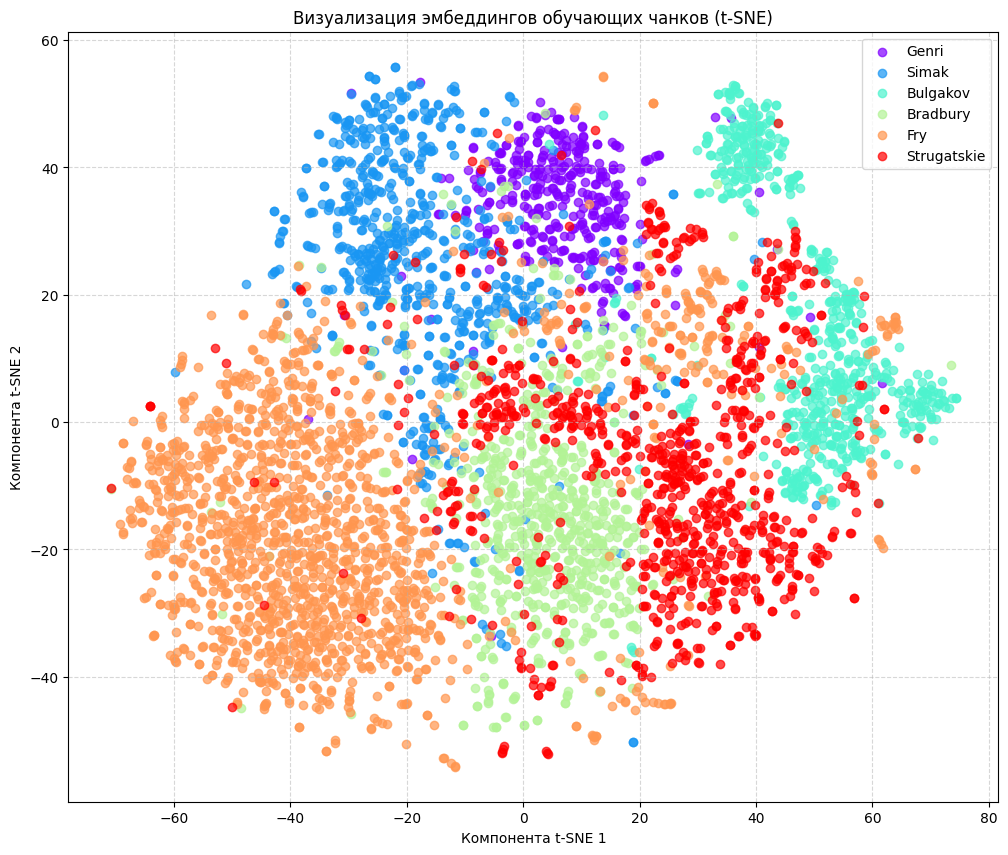


3. Анализ ошибочных предсказаний (на основе кросс-валидации)...
   - Всего ошибок на кросс-валидации: 2152 из 16556 (13.00%)

   Примеры ошибочно классифицированных чанков (до 10):

   Пример 1:
     Истинный автор: Genri (ID: 0)
     Предсказанный автор: Strugatskie (ID: 5)
     Текст чанка: 'Он вошел в огороженное место. Под навесами стояло много лошадей, жевавших овес и рожь. На дворе стояло много фургонов и телег с упряжью, небрежно брошенной на оглобли. Кудряш догадался, что это был од...'

   Пример 2:
     Истинный автор: Simak (ID: 1)
     Предсказанный автор: Fry (ID: 4)
     Текст чанка: 'Может, на самом деле он и не изменился, но такое у меня чувство. Мэй принесла пиво и забрала пустые кружки. — Придумал! — сказал Элф. — Хочешь послушать? — Конечно. Отчего не послушать. — Через денек-...'

   Пример 3:
     Истинный автор: Simak (ID: 1)
     Предсказанный автор: Genri (ID: 0)
     Текст чанка: 'Ни один куст в здравом уме и твердой памяти не отрастит вместо листьев банкноты 

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import numpy as np

print("\n--- Запуск дополнительного анализа ---")

id_to_author_map = {v: k for k, v in author_to_id_map.items()}
author_names = [id_to_author_map[i] for i in sorted(id_to_author_map.keys())] 

# --- 1. Матрица ошибок (на основе кросс-валидации) ---
print("\n1. Построение матрицы ошибок (кросс-валидация на обучающих данных)...")

if n_splits >= 2: 
    try:
        y_pred_cv = cross_val_predict(classifier, train_embeddings, train_author_ids, cv=n_splits, n_jobs=-1)

        cm = confusion_matrix(train_author_ids, y_pred_cv, labels=sorted(id_to_author_map.keys()))

        plt.figure(figsize=(10, 8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=author_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title(f'Матрица ошибок ({n_splits}-fold Cross-Validation)')
        plt.tight_layout() 
        plt.savefig("confusion_matrix_cv.png")
        plt.show()

    except Exception as e:
        print(f"   - Ошибка при построении матрицы ошибок: {e}")
        y_pred_cv = None
else:
    print("   - Пропуск построения матрицы ошибок: недостаточно фолдов для cross_val_predict (n_splits < 2).")
    y_pred_cv = None

# --- 2. Визуализация эмбеддингов (t-SNE) ---
print("\n2. Визуализация эмбеддингов обучающих чанков с помощью t-SNE...")
print("   (Может занять некоторое время для большого количества точек)")

embeddings_to_plot = train_embeddings
labels_to_plot = np.array(train_author_ids)
texts_to_plot = train_texts
indices_to_plot = np.arange(len(labels_to_plot))

MAX_POINTS_FOR_TSNE = 5000
if len(train_embeddings) > MAX_POINTS_FOR_TSNE:
    print(f"   - Слишком много точек ({len(train_embeddings)}), используется подвыборка из {MAX_POINTS_FOR_TSNE} точек для t-SNE.")
    from sklearn.model_selection import train_test_split
    _, sample_indices = train_test_split(
        indices_to_plot,
        test_size=MAX_POINTS_FOR_TSNE,
        stratify=labels_to_plot,
        random_state=42
    )
    embeddings_to_plot = train_embeddings[sample_indices]
    labels_to_plot = labels_to_plot[sample_indices]
    indices_to_plot = sample_indices

try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_to_plot)-1), n_iter=1000, verbose=1) # perplexity не должна превышать N-1
    embeddings_2d = tsne.fit_transform(embeddings_to_plot)

    # Создание графика
    plt.figure(figsize=(12, 10))
    unique_labels = sorted(np.unique(labels_to_plot))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels))) # Используем палитру rainbow

    for label, color in zip(unique_labels, colors):
        mask = labels_to_plot == label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=[color], label=id_to_author_map[label], alpha=0.7)

    plt.title('Визуализация эмбеддингов обучающих чанков (t-SNE)')
    plt.xlabel('Компонента t-SNE 1')
    plt.ylabel('Компонента t-SNE 2')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig("tsne_embeddings.png")
    plt.show()

except Exception as e:
    print(f"   - Ошибка при построении t-SNE: {e}")


# --- 3. Анализ ошибочных предсказаний (на основе кросс-валидации) ---
print("\n3. Анализ ошибочных предсказаний (на основе кросс-валидации)...")

if y_pred_cv is not None:
    misclassified_indices = np.where(y_pred_cv != train_author_ids)[0]
    num_misclassified = len(misclassified_indices)
    print(f"   - Всего ошибок на кросс-валидации: {num_misclassified} из {len(train_author_ids)} ({num_misclassified/len(train_author_ids)*100:.2f}%)")

    if num_misclassified > 0:
        print(f"\n   Примеры ошибочно классифицированных чанков (до 10):")
        np.random.shuffle(misclassified_indices) 
        for i, index in enumerate(misclassified_indices[:10]): 
            true_label_id = train_author_ids[index]
            pred_label_id = y_pred_cv[index]
            true_author = id_to_author_map[true_label_id]
            pred_author = id_to_author_map[pred_label_id]
            text_chunk = train_texts[index]

            print(f"\n   Пример {i+1}:")
            print(f"     Истинный автор: {true_author} (ID: {true_label_id})")
            print(f"     Предсказанный автор: {pred_author} (ID: {pred_label_id})")
            print(f"     Текст чанка: '{text_chunk[:200]}...'") 
    else:
        print("   - Ошибок на кросс-валидации не найдено!")
else:
    print("   - Пропуск анализа ошибок: предсказания кросс-валидации недоступны.")


print("\n--- Дополнительный анализ завершен ---")